In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Get some classifiers to evaluate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

# Explore and prep the dataset.
# I want to use this toy example to see if any dietary components correlate with covid deaths.
# There's a lot left out here, like recovery and many other factors 
# This is just to play with some ensemble methods. (Not dietary advice!)

loans_df = pd.read_csv("Loans.csv")
loans_df=loans_df.drop(['ID'], axis=1)
# We need to do some feature engineering here because these values are strings.
#discrete = ['ZIP Code','Personal Loan','Securities Account','CD Account','Online','CreditCard' ] 
#loans_df[discrete] = loans_df[discrete].astype(str)
print(loans_df.head())
print(loans_df.describe())

   Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
               Age   Experience       Income      ZIP Code       Family  \
count  5000.000000  5000.000000  5000.0000

Text(0.5, 1.0, 'feature correlations')

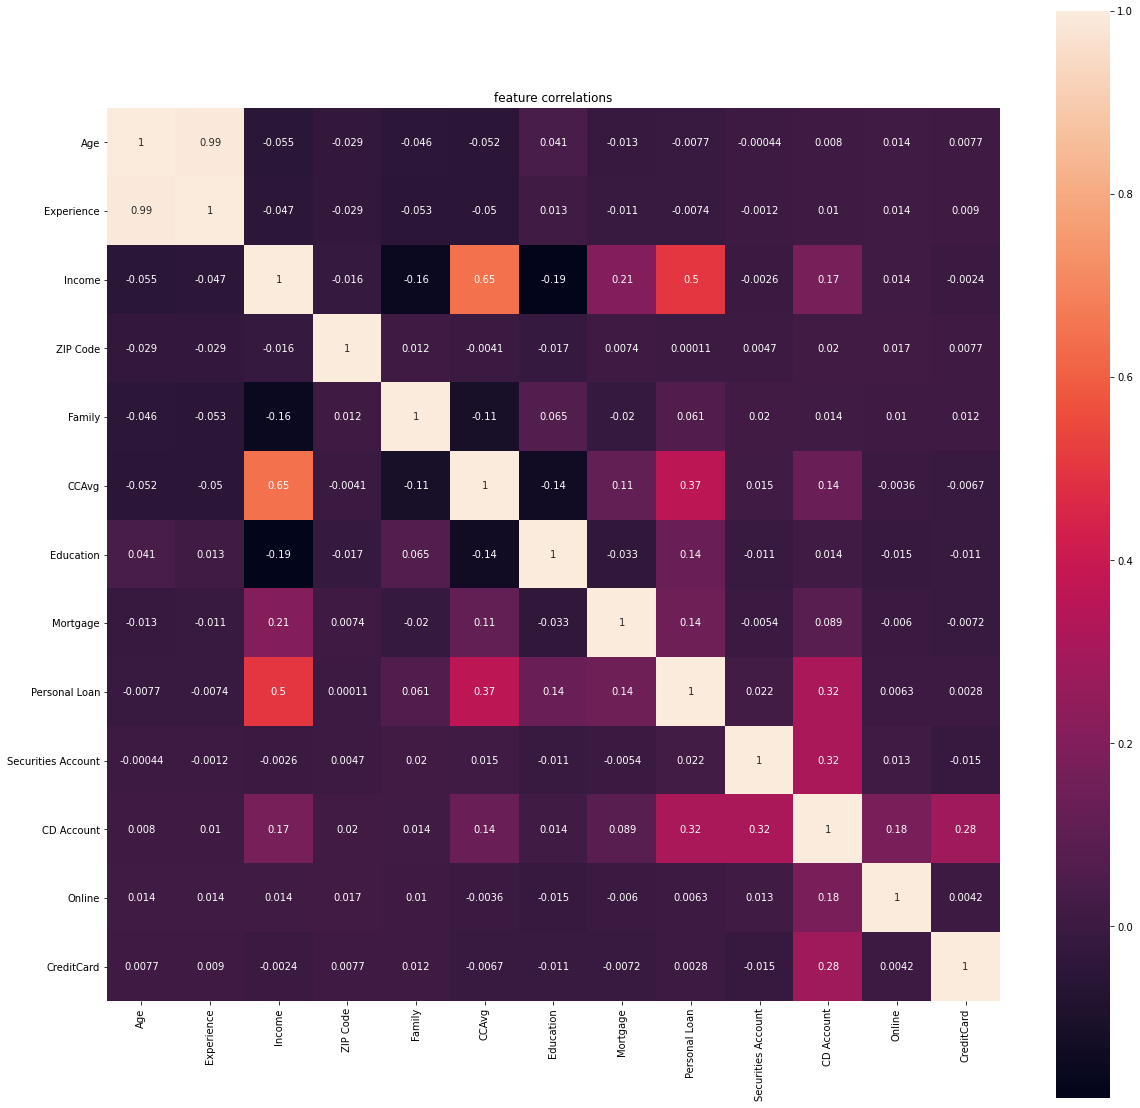

In [2]:
corr = loans_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, vmax=1, annot=True, square=True)
plt.title('feature correlations')

In [3]:
#income and CCavg are correlated with a sucessful loan, while education seems to have a negative effect on income and age/experience while very correalted are slightly negatively correlated with loan sucess.

In [4]:
#data exploration done so take out label.
y = [True if x == 1  else False for x in loans_df['Personal Loan']]
del loans_df['Personal Loan']
print(np.sum(y))

480


In [5]:
seed = 64
np.random.seed(seed)
X=(loans_df-loans_df.min())/(loans_df.max()-loans_df.min())
print(X)
#we will use cross-validation so we dont need to train/test/split

           Age  Experience    Income  ZIP Code    Family  CCAvg  Education  \
0     0.045455    0.086957  0.189815  0.936527  1.000000   0.16        0.0   
1     0.500000    0.478261  0.120370  0.924872  0.666667   0.15        0.0   
2     0.363636    0.391304  0.013889  0.977892  0.000000   0.10        0.0   
3     0.272727    0.260870  0.425926  0.970931  0.000000   0.27        0.5   
4     0.272727    0.239130  0.171296  0.939080  1.000000   0.10        0.5   
...        ...         ...       ...       ...       ...    ...        ...   
4995  0.136364    0.130435  0.148148  0.954731  0.000000   0.19        1.0   
4996  0.159091    0.152174  0.032407  0.947174  1.000000   0.04        0.0   
4997  0.909091    0.913043  0.074074  0.958463  0.333333   0.03        1.0   
4998  0.954545    0.934783  0.189815  0.924242  0.666667   0.05        0.5   
4999  0.113636    0.152174  0.347222  0.953758  0.666667   0.08        0.0   

      Mortgage  Securities Account  CD Account  Online  CreditC

Bagging, decresases variannce which makes it very sensitive to the training. 
Create the same model on different subsets of data.

In [6]:
#If bagging does poorly on small subsamples (poorly = less than baseline) then increase subsample size.
rf = RandomForestClassifier()
vanilla_scores = cross_val_score(rf, X, y, cv=10)
bagging_clf_04 = BaggingClassifier(rf, 
max_samples=0.4, max_features=10, random_state=seed)
bagging_scores_04 = cross_val_score(bagging_clf_04, X, y, cv=10,n_jobs=-1)
bagging_clf_001 = BaggingClassifier(rf, max_samples=0.01, max_features=10, random_state=seed)
bagging_scores_001 = cross_val_score(bagging_clf_001, X, y, cv=10, n_jobs=-1)
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(rf.__class__.__name__, 
                       vanilla_scores.mean(), vanilla_scores.std()))
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging 0.1 {0}]\n".format(rf.__class__.__name__, 
                        bagging_scores_001.mean(), bagging_scores_001.std()))
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging 0.4 {0}]".format(rf.__class__.__name__, 
                        bagging_scores_04.mean(), bagging_scores_04.std()))

Mean of: 0.988, std: (+/-) 0.003 [RandomForestClassifier]
Mean of: 0.909, std: (+/-) 0.008 [Bagging 0.1 RandomForestClassifier]

Mean of: 0.982, std: (+/-) 0.005 [Bagging 0.4 RandomForestClassifier]


In [7]:
#If bagging does poorly on small subsamples (poorly = less than baseline) then increase subsample size.
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=10)
    bagging_clf = BaggingClassifier(clf, 
       max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, 
       n_jobs=-1)
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, 
                       vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, 
                        bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.987, std: (+/-) 0.003 [RandomForestClassifier]
Mean of: 0.982, std: (+/-) 0.005 [Bagging RandomForestClassifier]

Mean of: 0.984, std: (+/-) 0.004 [ExtraTreesClassifier]
Mean of: 0.974, std: (+/-) 0.005 [Bagging ExtraTreesClassifier]

Mean of: 0.960, std: (+/-) 0.007 [KNeighborsClassifier]
Mean of: 0.946, std: (+/-) 0.008 [Bagging KNeighborsClassifier]

Mean of: 0.973, std: (+/-) 0.004 [SVC]
Mean of: 0.961, std: (+/-) 0.006 [Bagging SVC]

Mean of: 0.934, std: (+/-) 0.007 [RidgeClassifier]
Mean of: 0.929, std: (+/-) 0.005 [Bagging RidgeClassifier]



In [8]:
# Voting is one of the simplest way of combining the predictions from multiple machine learning algorithms. 
# hard/majority voting
from sklearn.ensemble import VotingClassifier
clf = [rf, et, knn, svc, rg]
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.99 (+/- 0.00) [Random Forest]
Accuracy: 0.98 (+/- 0.00) [Extra Trees]
Accuracy: 0.96 (+/- 0.01) [KNeighbors]
Accuracy: 0.97 (+/- 0.00) [SVC]
Accuracy: 0.93 (+/- 0.01) [Ridge Classifier]
Accuracy: 0.98 (+/- 0.00) [Ensemble]


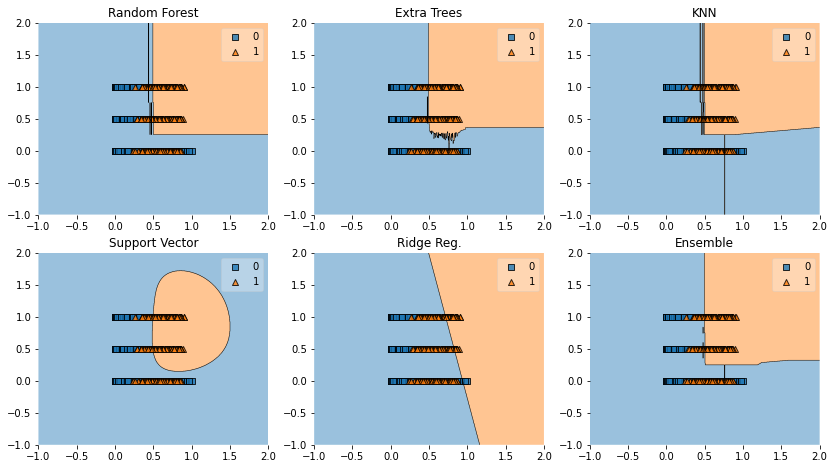

In [9]:
#visualize the decision boundary for a strong correlation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
decision_boundary=['Income', 'Education']
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(14, 12))
labels = ['Random Forest', 'Extra Trees', 'KNN', 'Support Vector',
          'Ridge Reg.', 'Ensemble']
for clf, lab, grd in zip([rf, et, knn, svc, rg, eclf], 
                         labels,
                         itertools.product([0, 1, 2], repeat = 2)):
    clf.fit(X[decision_boundary], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[decision_boundary]), 
                                y=np.array(y).astype(np.int64), clf=clf)
    plt.title(lab)

In [10]:
# None of these learning models seem to be fitting to the classes too well based on their decision boundaries.

Boosting add additional models sequentially.
Boosting reduces bias


In [11]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier 
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier

ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = xgb.XGBClassifier()
boost_array = [ada_boost, grad_boost, xgb_boost]
eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']
for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))


Mean: 0.967, std: (+/-) 0.004 [Ada Boost]
Mean: 0.986, std: (+/-) 0.002 [Grad Boost]
Mean: 0.988, std: (+/-) 0.002 [XG Boost]
Mean: 0.987, std: (+/-) 0.003 [Ensemble]


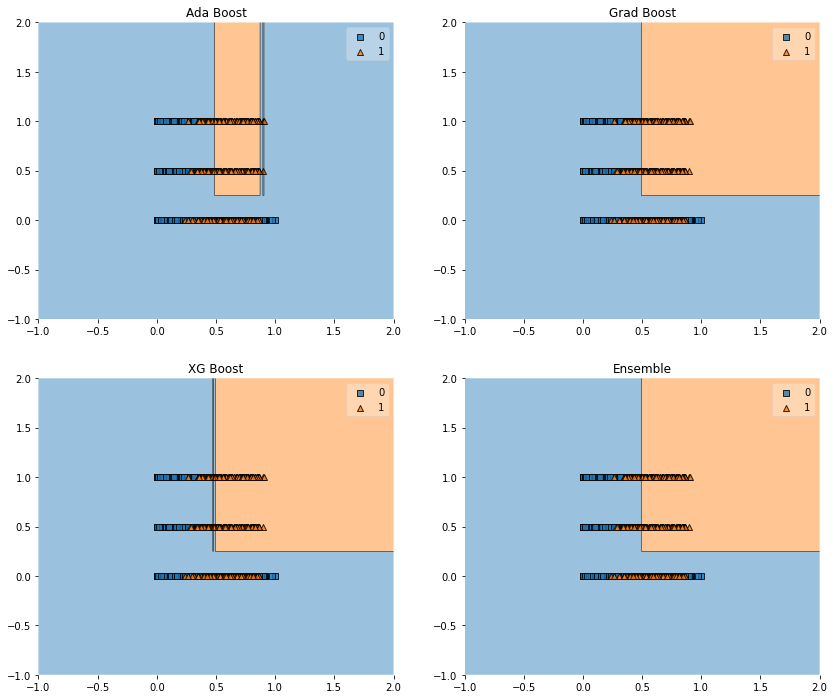

In [12]:
#Note: There is an issue with xgb and sklearn, if you get a feature mismatch error try with numpy arrays instead of dataframe.
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(14, 12))
for clf, lab, grd in zip([ada_boost, grad_boost, xgb_boost, eclf], 
                         labels,
                         itertools.product([0, 1], repeat = 2)):
    clf.fit(X[decision_boundary].to_numpy(), y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[decision_boundary].to_numpy()), 
                                y=np.array(y).astype(np.int64), 
                                clf=clf)
    plt.title(lab)

In [13]:
#Stacking: The predictions from the models are used as inputs for each sequential layer, and combined to form a new set of predictions
